<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
     <td align="left"; style="background-color:transparent; width: 33%;"><a href="http://www.math-evry.cnrs.fr/departement/doku.php?id=formation:master:m2ds"><img src="https://github.com/ramp-kits/scMARK_classification/raw/main/evry_logo.png" width="65%"></a></td>
    <td align="center"; style="background-color:transparent; width: 33%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/bovine_embryo_survival_prediction/raw/main/DATAIA-h.png" width="80%"></a></td>
    <td align="right"; style="background-color:transparent; width: 33%;"><a href="https://www.inrae.fr"><img src="https://www.inrae.fr/themes/custom/inrae_socle/logo.svg" width="40%"></a></td>
  </tr>
</table>
</div>


<center><h1>Single-cell RNA-seq classification</h1></center>

<center><h3>A RAMP data-challenge on the prediction of cellular types based on genes expression level </h3></center>
<br/>


<center><i>Nicolas Jouvin (MIA Paris-Saclay, Associate Professor @ Univ. Paris-Saclay), François Caud (DATAIA, Univ. Paris-Saclay) </i></center>

<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision.

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

# Setup

If marked as `code`, the two following cells will

* install the required package dependencies
* download the public data on OSF

They are disabled by default since you only have to call these command once (in your dedicated Python env). You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

<div class="alert alert-block alert-info">
<b>Info:</b> Due to the structure of the challenge, libraries not included in `requirements.txt` will need to be added via a pull request to the <a href=https://github.com/ramp-kits/scMARK_classification> GitHub repo </a>.
</div>

In [ ]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb


In [ ]:
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Locate and switch to the project directory
candidates = glob.glob('/content/drive/MyDrive/scMARK*') + \
             glob.glob('/content/drive/MyDrive/*/scMARK*')

assert candidates, "No folder starting with 'scMARK' found in MyDrive."

# Select the shortest path match and change directory
PROJECT_DIR = sorted(candidates, key=len)[0]
os.chdir(PROJECT_DIR)
print(f"Current directory: {os.getcwd()}")
print(f"Directory contents: {os.listdir()[:20]}")

# 3. Install dependencies
if os.path.exists('requirements.txt'):
    print("Installing dependencies from requirements.txt...")
    !pip -q install -r requirements.txt
else:
    print("requirements.txt not found. Installing default packages...")
    !pip -q install numpy pandas scipy scikit-learn matplotlib anndata scanpy

# 4. Download data (if script exists)
if os.path.exists('download_data.py'):
    print("Running download_data.py...")
    !python download_data.py
else:
    print("download_data.py not found (data might already be present).")

# 5. Add current directory to system path
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

# 6. Verify imports
try:
    from problem import get_train_data, get_test_data
    print("✅ Successfully imported functions from problem.py.")

    # Optional: Quick shape check
    X_train, y_train = get_train_data()
    print(f"Training data shape: {getattr(X_train, 'shape', 'Unknown')}")

except Exception as e:
    print("❌ Import failed. Please check if 'problem.py' exists in the current directory.")
    raise e

Mounted at /content/drive
Current directory: /content/drive/MyDrive/scMARK_classification_2025_nov
Directory contents: ['.gitignore', 'problem.py', 'download_data.py', 'README.md', 'environment.yml', 'requirements.txt', 'extra_libraries.txt', 'evry_logo.png', 'scMARK_classification_starting_kit.html', '__pycache__', 'data', '.git', 'submissions', '.github', 'class_distribution.png', 'scMARK_classification_starting_kit.ipynb']
Installing dependencies from requirements.txt...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 42.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.1/130.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.4 MB/s eta 0:00:00
   ━━

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


✅ Successfully imported functions from problem.py.
Training data shape: (1000, 14059)


In [ ]:
import scanpy as sc
import anndata
import problem
from problem import get_train_data, get_test_data

# The data

### Loading data
Raw data are stored in h5ad format which can be read via the `scanpy.read_h5ad` function which returns an [AnnData](https://anndata.readthedocs.io/) object.

The `problem.py` file contains the definition of the data-challenge according to the RAMP framework. In addition, it contains an helper functions to import data.

In [ ]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

#### Labels proportions
A first inspection of the labels indicates that the classes are imbalanced.
> Note: the same analysis may be conducted for y_test.

In [ ]:
lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)

,proportion
label,
T_cells_CD8+,0.342
T_cells_CD4+,0.336
Cancer_cells,0.237
NK_cells,0.085


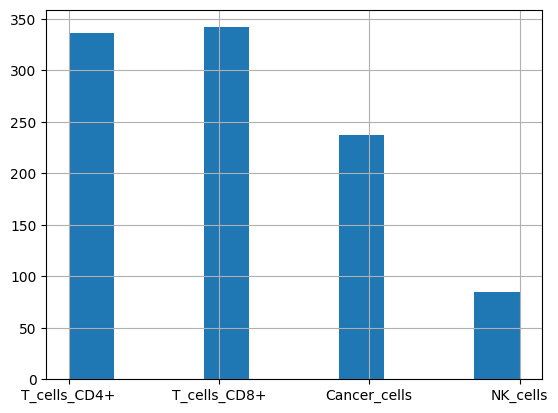

In [ ]:
lab_df.label.hist();

#### Sparse matrix and NumPy arrays

Secondly, looking at the features

In [ ]:
print(X_train.shape)
print(type(X_train))

(1000, 14059)
<class 'scipy.sparse._csr.csr_matrix'>


We see that we have a fairly high dimensional problem with 1000 data points (unique cells) described by 14059 variables (genes). Since we measure expression level, the data is quite sparse, with many unexpressed genes for each cell. Thus, `get_*_data()` functions returns $X$ as a `scipy` [sparse matrix stored in row format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). This is useful

    1. To save memory space
    2. Some algorithm may work with scipy's sparse CSR matrices.

Of course many existing algorithm, *e.g.* in scikit-learn, may throw error when given such an object, requiring a `np.array` type. Thankfully the `.toarray()` method straightforwadly converts to NumPy.

In [ ]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### A first look at the data

<div class="alert alert-block alert-warning">
<b>Warning:</b> This section purposedly presents a naive example of data manipulation. It is expected of you to dive deeper into the data analysis and do proper pre-processing.

</div>


A particularity of RNA-seq data is that total counts may vary widely between cells and/or genes.


In [ ]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

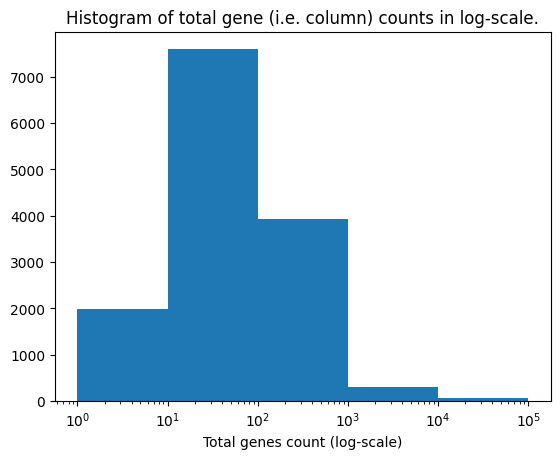

In [ ]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

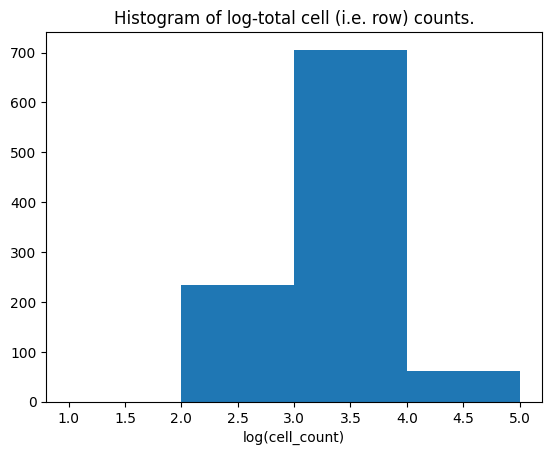

In [ ]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

This suggests for some normalization of the counts. There are many normalization possible for RNA-seq data, and one of the goal of this challenge is to test for different pre-processing. For simplicity, here we choose to normalize each row (cell) by its total count.

In [ ]:
def preprocess_X(X):
    X = X.toarray()
    return X / X.sum(axis=1)[:, np.newaxis]

X_train_norm = preprocess_X(X_train)
# sanity check
np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0]))

True

# The score function

This challenge scores your submissions and ranks participants with a balanced accuracy score, computed via the (unadjusted) sklearn's `balanced_accuracy_score` function.

Balanced accuracy is computed as the average of Recall scores for each class [see implementation for more details](https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b/sklearn/metrics/_classification.py#L2180). It is between 0 and 1, the higher, the better.

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
# this custom class is used by the challenge and calls
# balanced_accuracy_score(y_true, y_pred, adjusted=False)
# under the hood
from problem import BalancedAccuracy

# A first (naive) try at the challenge
We now show a first naive attempt at the challenge, and will proceed in two steps :

    1. First, we will construct a classifier step-by-step.
    2. Then, we will show how to implement this classifier as a proper RAMP submision.
## Step-by-step construction of a classifier

Given the high-dimensional nature of the problem we will construct a classifier: standardize data, do a PCA retaining only the 50 first components, and finally fit a random forest classifier on the 50 first components.

This can be easily implemented as a scikit-learn `Pipeline`.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 50 components", PCA(n_components=50)),
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=5, n_estimators=100, max_features=3
            ),
        ),
    ]
)

pipe

Pipeline(steps=[('Scaler', StandardScaler()),
                ('PCA with 50 components', PCA(n_components=50)),
                ('Random Forest Classifier',
                 RandomForestClassifier(max_depth=5, max_features=3))])

In [ ]:
# fit on train
pipe.fit(X_train_norm, y_train)
y_tr_pred = pipe.predict(X_train_norm)

# predict on test
X_test_norm = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_norm)


Train balanced accuracy : 0.703
Test balanced accuracy : 0.588


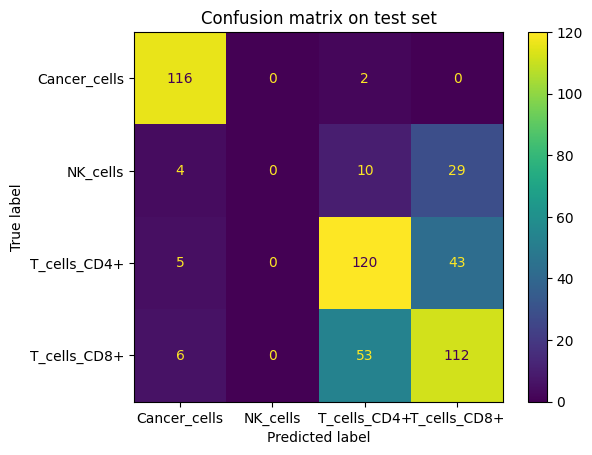

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

This naive classifier does a better job than a dummy random classifier which would yield an average balanced accuracy of 1/4.
However, it never predicts the "NK_cell" type and seems to confuse between the two different "T-cell" types. There seems to be room for improvement. Good news, it is your job ! :)

Next, let's see how to implement this exact same classifier as a receivable RAMP submission

# **Optimiser le modèle Random Forest via Grid Search.**

In [ ]:


pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA",    PCA()),
        ("RF",     RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42)),
    ]
)

param_grid = {
    "PCA__n_components": [30, 50, 80, 120 ,150],
    "RF__n_estimators":  [100, 300],
    "RF__max_depth":     [5, 10, None],
    "RF__min_samples_leaf": [1, 5, 10],
    "RF__max_features":  [3, "sqrt"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train_norm, y_train)

print("CV best balanced acc:", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_
y_te_pred_best = best_model.predict(X_test_norm)
print("Test balanced acc with best model:", balanced_accuracy_score(y_test, y_te_pred_best))


Fitting 5 folds for each of 144 candidates, totalling 720 fits


KeyboardInterrupt: 

In [ ]:


# Reconstruct the pipeline using the best parameters found by GridSearchCV
pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA", PCA(n_components=80)),                        # ★ Best parameter
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=5,                                    # ★ Best parameter
                n_estimators=200,                               # ★ Best parameter
                max_features=0.4,                               # ★ Best parameter
                min_samples_leaf=7,                             # ★ Best parameter
                class_weight="balanced",                        # Recommended to address class imbalance
                random_state=42,
                max_samples=0.7,                                # Strong prevention of overfitting
                n_jobs=-1,
                oob_score=True,
            ),
        ),
    ]
)


In [ ]:
# fit on train
pipe.fit(X_train_norm, y_train)
y_tr_pred = pipe.predict(X_train_norm)

# predict on test
X_test_norm = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_norm)


Train balanced accuracy : 0.830
Test  balanced accuracy : 0.655


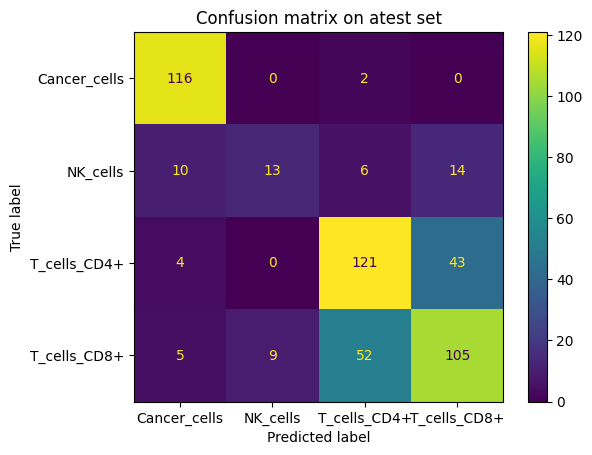

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test  balanced accuracy : {balanced_accuracy_score(y_test,  y_te_pred):.3f}")

# confusion matrix
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot(cmap="viridis")
plt.title("Confusion matrix on atest set")
plt.show()


In [ ]:
# Reconstruct the pipeline using the best parameters found by GridSearchCV
pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA", PCA(n_components=200)),                        # ★ Best parameter
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=5,                                    # ★ Best parameter
                n_estimators=200,                               # ★ Best parameter
                max_features=0.4,                               # ★ Best parameter
                min_samples_leaf=7,                             # ★ Best parameter
                class_weight="balanced",                        # Recommended to address class imbalance
                random_state=42,
                max_samples=0.7,                                # Strong prevention of overfitting
                n_jobs=-1,
                oob_score=True,
            ),
        ),
    ]
)


In [ ]:
# fit on train
pipe.fit(X_train_norm, y_train)
y_tr_pred = pipe.predict(X_train_norm)

# predict on test
X_test_norm = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_norm)


Train balanced accuracy : 0.864
Test  balanced accuracy : 0.649


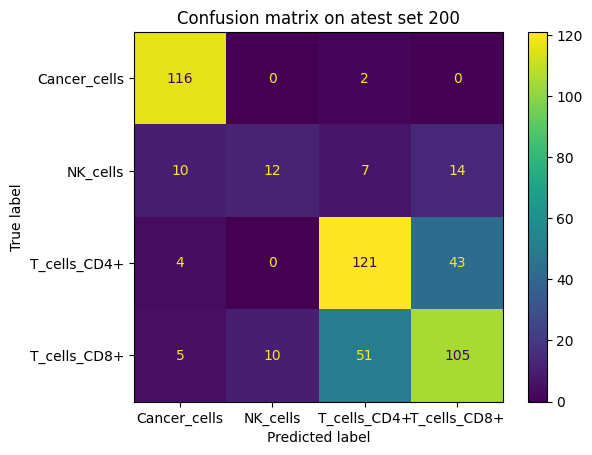

In [ ]:
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test  balanced accuracy : {balanced_accuracy_score(y_test,  y_te_pred):.3f}")

# confusion matrix
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot(cmap="viridis")
plt.title("Confusion matrix on atest set 200")
plt.show()

# **Logical Regression**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg Train balanced accuracy : 0.862
LogReg Test  balanced accuracy : 0.698


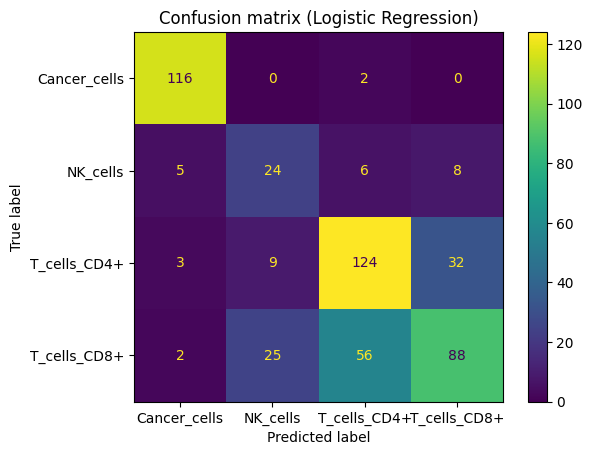

In [ ]:
logit_pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA", PCA(n_components=80)),
        (
            "LogReg",
            LogisticRegression(
                multi_class="multinomial",
                class_weight="balanced",
                max_iter=500,
                n_jobs=-1,
                random_state=42,
            ),
        ),
    ]
)

logit_pipe.fit(X_train_norm, y_train)
y_tr_pred = logit_pipe.predict(X_train_norm)
y_te_pred = logit_pipe.predict(X_test_norm)

print(f"LogReg Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"LogReg Test  balanced accuracy : {balanced_accuracy_score(y_test,  y_te_pred):.3f}")

cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logit_pipe.classes_)
disp.plot(cmap="viridis")
plt.title("Confusion matrix (Logistic Regression)")
plt.show()


# **XGBoost**

In [ ]:
!pip install xgboost

Label classes: ['Cancer_cells' 'NK_cells' 'T_cells_CD4+' 'T_cells_CD8+']
XGB Train balanced accuracy : 1.000
XGB Test  balanced accuracy : 0.786


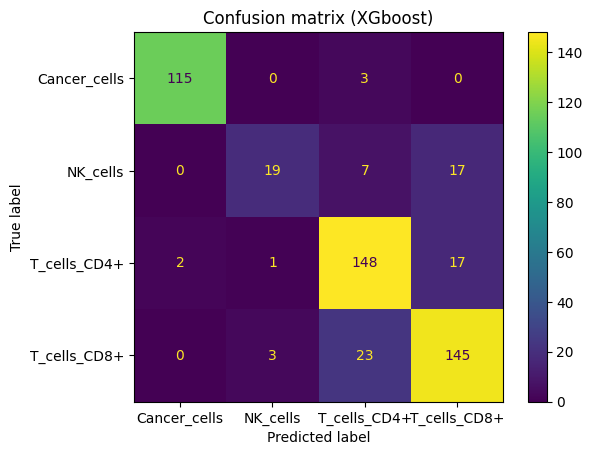

In [ ]:
# 1. Encode labels (String -> Integer)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
print("Label classes:", le.classes_)

# 2. Define XGBoost model
xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    eval_metric="mlogloss",
)

# 3. Train model
# The model will treat all samples equally.
xgb_clf.fit(
    X_train, y_train_enc
)

# 4. Make predictions
y_tr_pred_enc = xgb_clf.predict(X_train)
y_te_pred_enc = xgb_clf.predict(X_test)

# 5. Evaluate (Balanced Accuracy)
print(f"XGB Train balanced accuracy : {balanced_accuracy_score(y_train_enc, y_tr_pred_enc):.3f}")
print(f"XGB Test  balanced accuracy : {balanced_accuracy_score(y_test_enc,  y_te_pred_enc):.3f}")

# 6. Plot Confusion Matrix
cm = confusion_matrix(y_test_enc, y_te_pred_enc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="viridis")
plt.title("Confusion matrix (XGboost)")
plt.show()

# **Optimiser et gérer le bruit des données**

In [ ]:
# 1. Load raw data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

print(f"Original training shape: {X_train.shape}")

# Convert to AnnData objects for Scanpy preprocessing
adata_train = sc.AnnData(X_train)
adata_test = sc.AnnData(X_test)

# --- Step 1: Filtering ---
# Filter out genes expressed in fewer than 3 cells to remove noise
print("Filtering low quality genes...")
sc.pp.filter_genes(adata_train, min_cells=3)

# Ensure feature alignment: keep only valid training genes in the test set
common_genes = adata_train.var_names
adata_test = adata_test[:, common_genes].copy()

# --- Step 2: Normalization ---
# Normalize total counts per cell to 10,000 (CPM)
print("Normalizing...")
sc.pp.normalize_total(adata_train, target_sum=1e4)
sc.pp.normalize_total(adata_test, target_sum=1e4)

# --- Step 3: Log Transformation ---
# Apply log1p transformation (log(x+1))
print("Applying Log1p transformation...")
sc.pp.log1p(adata_train)
sc.pp.log1p(adata_test)

# --- Step 4: Feature Selection ---
# Select the top 2000 Highly Variable Genes (HVGs)
print("Selecting Highly Variable Genes...")
sc.pp.highly_variable_genes(adata_train, n_top_genes=2000, subset=True)

# Subset test set to the same 2000 genes
adata_test = adata_test[:, adata_train.var_names].copy()

print(f"Shape after feature selection: {adata_train.shape}")

# --- Step 5: Scaling ---
# Standardize features (mean=0, variance=1) using sklearn
print("Scaling data...")
scaler = StandardScaler(with_mean=True, with_std=True)

# Convert back to numpy array for training (densifying the matrix)
X_train_processed = scaler.fit_transform(adata_train.X.toarray())
X_test_processed = scaler.transform(adata_test.X.toarray())

print("Preprocessing complete!")
print(f"Final training shape: {X_train_processed.shape}")
print(f"Final test shape: {X_test_processed.shape}")

# --- Processed data is ready for models (RF, XGBoost, etc.) ---

Original training shape: (1000, 14059)
Filtering low quality genes...
Normalizing...
Applying Log1p transformation...
Selecting Highly Variable Genes...
Shape after feature selection: (1000, 2000)
Scaling data...
Preprocessing complete!
Final training shape: (1000, 2000)
Final test shape: (500, 2000)


# **Random Forest**

Random Forest Train Balanced Acc: 0.878
Random Forest Test  Balanced Acc: 0.747


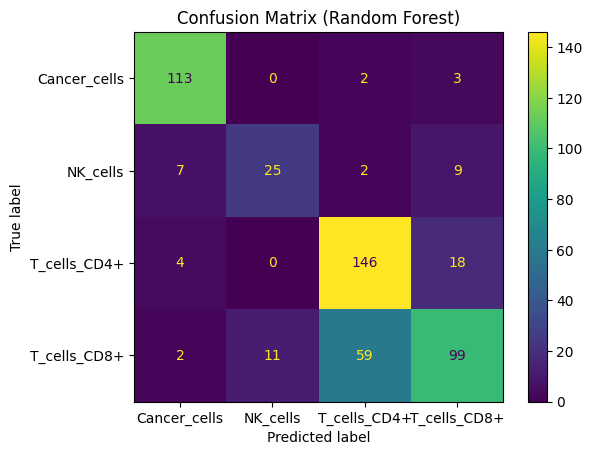

In [ ]:

rf_pipe = Pipeline([
    ("PCA", PCA(n_components=80)),
    ("RF", RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        max_features=0.4,
        min_samples_leaf=7,
        class_weight="balanced",
        max_samples=0.7,
        n_jobs=-1,
        random_state=42
    ))
])


rf_pipe.fit(X_train_processed, y_train)

# prediction
y_tr_pred = rf_pipe.predict(X_train_processed)
y_te_pred = rf_pipe.predict(X_test_processed)

print(f"Random Forest Train Balanced Acc: {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Random Forest Test  Balanced Acc: {balanced_accuracy_score(y_test, y_te_pred):.3f}")

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_te_pred, cmap="viridis")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

# **logical Regression**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg Train Balanced Acc: 0.915
LogReg Test  Balanced Acc: 0.744


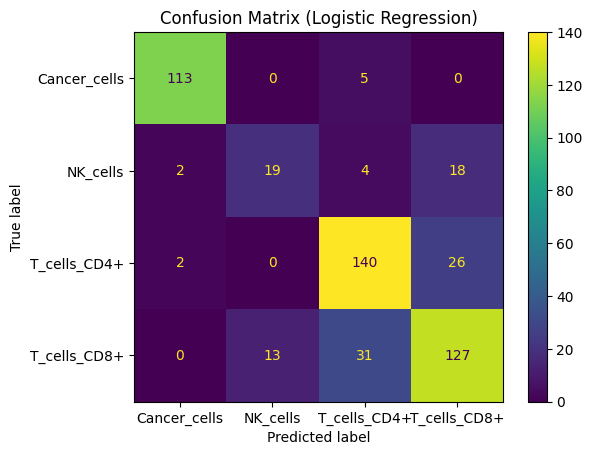

In [ ]:
from sklearn.linear_model import LogisticRegression


logit_pipe = Pipeline([
    ("PCA", PCA(n_components=80)),
    ("LogReg", LogisticRegression(
        multi_class="multinomial",
        class_weight="balanced",
        max_iter=500,
        n_jobs=-1,
        random_state=42
    ))
])


logit_pipe.fit(X_train_processed, y_train)

# prediction
y_tr_pred_log = logit_pipe.predict(X_train_processed)
y_te_pred_log = logit_pipe.predict(X_test_processed)

print(f"LogReg Train Balanced Acc: {balanced_accuracy_score(y_train, y_tr_pred_log):.3f}")
print(f"LogReg Test  Balanced Acc: {balanced_accuracy_score(y_test, y_te_pred_log):.3f}")


ConfusionMatrixDisplay.from_predictions(y_test, y_te_pred_log, cmap="viridis")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

# **XGboost**

Training XGBoost (no sample weights)...
XGBoost Train Balanced Acc: 1.000
XGBoost Test  Balanced Acc: 0.809


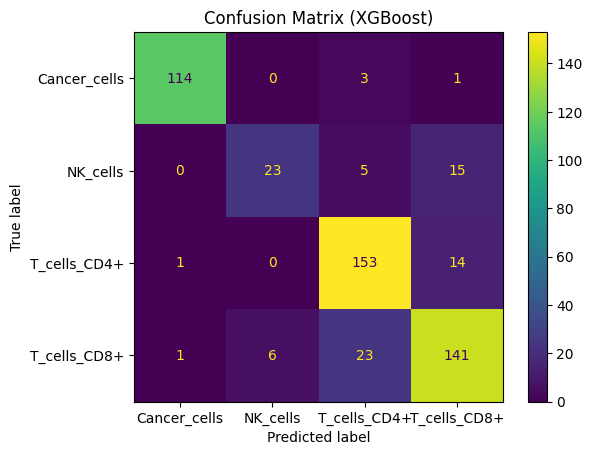

In [ ]:


# 1. Label Encoding (String -> Int)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 2. Get class info (No sample weights calculated here)
classes = np.unique(y_train_enc)

# 3. Define the model
# Using parameters suitable for the processed data
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(classes),
    learning_rate=0.1,
    n_estimators=200,
    max_depth=5,
    n_jobs=-1,
    random_state=42,
    tree_method="hist" # Accelerates training
)

# 4. Training (Input: X_train_processed)
print("Training XGBoost (no sample weights)...")

# Fit without sample_weights; the model treats all samples equally
xgb_clf.fit(X_train_processed, y_train_enc)

# 5. Prediction
y_tr_pred_xgb = xgb_clf.predict(X_train_processed)
y_te_pred_xgb = xgb_clf.predict(X_test_processed)

# 6. Evaluation
print(f"XGBoost Train Balanced Acc: {balanced_accuracy_score(y_train_enc, y_tr_pred_xgb):.3f}")
print(f"XGBoost Test  Balanced Acc: {balanced_accuracy_score(y_test_enc, y_te_pred_xgb):.3f}")

# 7. Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_te_pred_xgb,
    display_labels=le.classes_,
    cmap="viridis"
)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

Training XGBoost...
XGBoost Train Balanced Acc: 1.000
XGBoost Test  Balanced Acc: 0.828


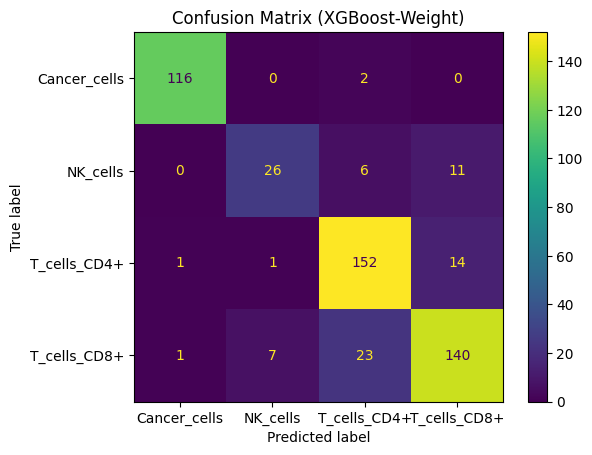

In [ ]:


# 1. Label Encoding (String -> Int)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 2. Calculate weights (Handle class imbalance)
classes = np.unique(y_train_enc)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_enc)
sample_weights = weights[y_train_enc]  # Assign weight to each sample

# 3. Define model
# We pass the processed high-variable gene data directly to XGBoost
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(classes),
    learning_rate=0.1,
    n_estimators=200,
    max_depth=4,
    n_jobs=-1,
    random_state=42,
    tree_method="hist" # Accelerates training
)

# 4. Training (Input: X_train_processed)
print("Training XGBoost...")
xgb_clf.fit(X_train_processed, y_train_enc, sample_weight=sample_weights)

# 5. Prediction
y_tr_pred_xgb = xgb_clf.predict(X_train_processed)
y_te_pred_xgb = xgb_clf.predict(X_test_processed)

# 6. Evaluation
print(f"XGBoost Train Balanced Acc: {balanced_accuracy_score(y_train_enc, y_tr_pred_xgb):.3f}")
print(f"XGBoost Test  Balanced Acc: {balanced_accuracy_score(y_test_enc, y_te_pred_xgb):.3f}")

# 7. Plotting (Displaying original label names)
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_te_pred_xgb,
    display_labels=le.classes_,
    cmap="viridis"
)
plt.title("Confusion Matrix (XGBoost-Weight)")
plt.show()

Training XGBoost...
XGBoost Train Balanced Acc: 0.963
XGBoost Test  Balanced Acc: 0.823


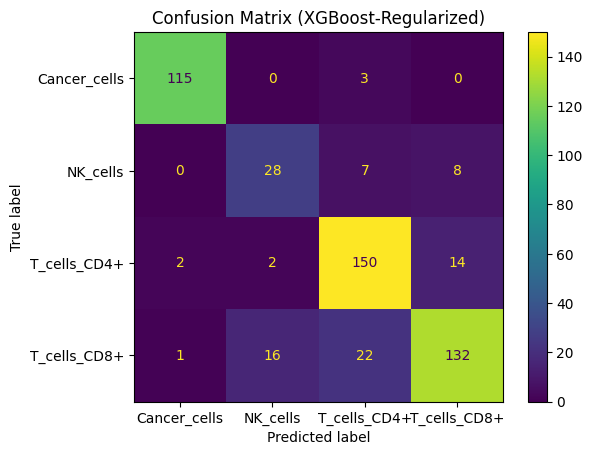

In [ ]:
# 1. Label Encoding (String -> Int)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 2. Calculate weights (Handle class imbalance)
classes = np.unique(y_train_enc)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_enc)
sample_weights = weights[y_train_enc]  # Assign weight to each sample

# 3. Define model
# We pass the processed high-variable gene data directly to XGBoost
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(classes),
    learning_rate=0.05,
    n_estimators=600,
    max_depth=4,
    min_child_weight=6,
    gamma=1.5,
    reg_lambda=2.0,
    reg_alpha=0.5,
    subsample=0.7,
    colsample_bytree=0.6,
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

# 4. Training (Input: X_train_processed)
print("Training XGBoost...")
xgb_clf.fit(X_train_processed, y_train_enc, sample_weight=sample_weights)

# 5. Prediction
y_tr_pred_xgb = xgb_clf.predict(X_train_processed)
y_te_pred_xgb = xgb_clf.predict(X_test_processed)

# 6. Evaluation
print(f"XGBoost Train Balanced Acc: {balanced_accuracy_score(y_train_enc, y_tr_pred_xgb):.3f}")
print(f"XGBoost Test  Balanced Acc: {balanced_accuracy_score(y_test_enc, y_te_pred_xgb):.3f}")

# 7. Plotting (Displaying original label names)
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_te_pred_xgb,
    display_labels=le.classes_,
    cmap="viridis"
)
plt.title("Confusion Matrix (XGBoost-Regularized)")
plt.show()

Starting comparison training...
Training Baseline (Depth=4)...
Training Optimized (Regularized)...


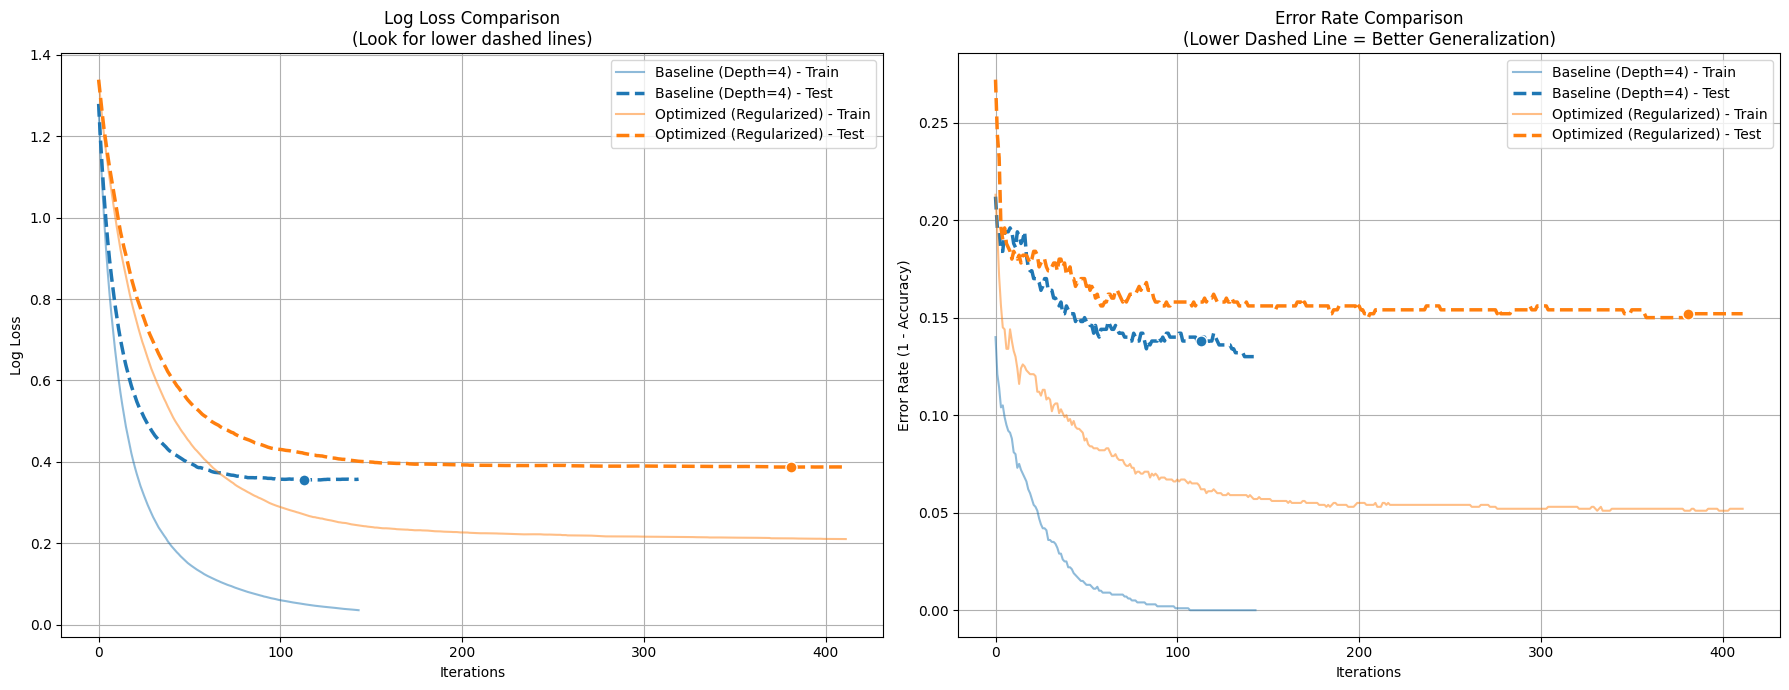


Model Name                | Train Acc  | Test Acc  
------------------------------------------------------------
Baseline (Depth=4)        | 1.0000     | 0.8234
Optimized (Regularized)   | 0.9621     | 0.8212


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score

# ==========================================
# 1. Define Models
# ==========================================

# --- Model A: Baseline (Simple) ---
# Standard parameters, potentially high variance (overfitting)
model_a = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(classes),
    learning_rate=0.1,
    n_estimators=200,
    max_depth=4,
    n_jobs=-1,
    random_state=42,
    tree_method="hist",

    # Required for plotting curves:
    early_stopping_rounds=30,
    eval_metric=["merror", "mlogloss"]
)

# --- Model B: Optimized (Strong Regularization) ---
# Low learning rate, structural constraints, L1/L2 regularization
model_b = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(classes),

    # Reduced Capacity
    learning_rate=0.05,       # Slower learning
    n_estimators=600,         # More trees
    max_depth=4,              # Same depth

    # Structural Constraints (The "Brakes")
    min_child_weight=6,       # High threshold for leaf nodes
    gamma=1.5,                # High threshold for splitting

    # Regularization (The "Noise Filters")
    reg_lambda=2.0,           # L2
    reg_alpha=0.5,            # L1
    subsample=0.7,            # Randomness
    colsample_bytree=0.6,     # Randomness

    n_jobs=-1,
    random_state=42,
    tree_method="hist",

    # Required for plotting curves:
    early_stopping_rounds=30,
    eval_metric=["merror", "mlogloss"]
)

# ==========================================
# 2. Train Both Models
# ==========================================
# We rename them for the plot legend
models = [
    ("Baseline (Depth=4)", model_a),
    ("Optimized (Regularized)", model_b)
]
results_dict = {}

print("Starting comparison training...")
for name, clf in models:
    print(f"Training {name}...")
    clf.fit(
        X_train_processed,
        y_train_enc,
        sample_weight=sample_weights,
        eval_set=[(X_train_processed, y_train_enc), (X_test_processed, y_test_enc)],
        verbose=False
    )
    results_dict[name] = clf.evals_result()

# ==========================================
# 3. Plot on ONE Chart (Overlay)
# ==========================================
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Define colors: Blue for Baseline, Orange for Optimized
colors = {
    "Baseline (Depth=4)": "tab:blue",
    "Optimized (Regularized)": "tab:orange"
}

for name, clf in models:
    history = results_dict[name]
    epochs = len(history['validation_0']['mlogloss'])
    x_axis = range(epochs)
    c = colors[name]

    # --- Left Plot: Log Loss ---
    # Solid line = Train, Dashed line = Test
    ax[0].plot(x_axis, history['validation_0']['mlogloss'], color=c, linestyle='-', alpha=0.5, label=f'{name} - Train')
    ax[0].plot(x_axis, history['validation_1']['mlogloss'], color=c, linestyle='--', linewidth=2.5, label=f'{name} - Test')

    # --- Right Plot: Error Rate ---
    ax[1].plot(x_axis, history['validation_0']['merror'], color=c, linestyle='-', alpha=0.5, label=f'{name} - Train')
    ax[1].plot(x_axis, history['validation_1']['merror'], color=c, linestyle='--', linewidth=2.5, label=f'{name} - Test')

    # Mark best iteration with a dot
    if hasattr(clf, "best_iteration") and clf.best_iteration is not None:
        best_idx = clf.best_iteration
        best_loss = history['validation_1']['mlogloss'][best_idx]
        best_err = history['validation_1']['merror'][best_idx]

        ax[0].plot(best_idx, best_loss, marker='o', color=c, markersize=8, markeredgecolor='white')
        ax[1].plot(best_idx, best_err, marker='o', color=c, markersize=8, markeredgecolor='white')


# Formatting Plot 1
ax[0].set_title("Log Loss Comparison\n(Look for lower dashed lines)")
ax[0].set_ylabel("Log Loss")
ax[0].set_xlabel("Iterations")
ax[0].legend()
ax[0].grid(True)

# Formatting Plot 2
ax[1].set_title("Error Rate Comparison\n(Lower Dashed Line = Better Generalization)")
ax[1].set_ylabel("Error Rate (1 - Accuracy)")
ax[1].set_xlabel("Iterations")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# ==========================================
# 4. Final Scores
# ==========================================
print("\n" + "="*60)
print(f"{'Model Name':<25} | {'Train Acc':<10} | {'Test Acc':<10}")
print("-" * 60)

for name, clf in models:
    y_tr = clf.predict(X_train_processed)
    y_te = clf.predict(X_test_processed)
    acc_tr = balanced_accuracy_score(y_train_enc, y_tr)
    acc_te = balanced_accuracy_score(y_test_enc, y_te)
    print(f"{name:<25} | {acc_tr:.4f}     | {acc_te:.4f}")
print("="*60)

## Designing the RAMP submission
The RAMP challenge is automatized and a submission requires a specific structure described below.


### Mandatory structure of a submission


A submission is stored in `./submissions/<submission_foldername>/` and must contain a Python file named `classifier.py`.

This python script must itself implement (at least) a custom `Classifier` class with
 * A `fit(X, y)` method.
 * A `predict_proba(X)` method.

**Warning**: the `X` argument must be understood as the sparse CSR count data matrix obtained by `get_train_data()`. Thus any pre-processing of the count matrix must be done inside the methods.

We illustrate this below with the naive classifier already implemented.

### Illustration with the naive classifier

> Note: The following class is also implemented in `./submissions/starting_kit/classifier.py`.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


def _preprocess_X(X_sparse):
    # cast a dense array
    X = X_sparse.toarray()

    # normalize each row
    return X / X.sum(axis=1)[:, np.newaxis]


class Classifier(object):
    def __init__(self):
        # Use scikit-learn's pipeline
        self.pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            PCA(n_components=50),
            RandomForestClassifier(
                max_depth=5, n_estimators=100,
                max_features=3
            ),
        )

    def fit(self, X_sparse, y):
        X = _preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        self.classes_ = self.pipe.classes_
        pass

    def predict_proba(self, X_sparse):
        X = _preprocess_X(X_sparse)
        # here we use RandomForest.predict_proba()
        return self.pipe.predict_proba(X)


Below is a simplified version of what RAMP does with your submission.

In [ ]:
clf = Classifier()
clf.fit(X_train, y_train)
# predict_proba
y_tr_pred_proba = clf.predict_proba(X_train)
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

In [ ]:
print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

Train balanced accuracy: 0.6813750489091929
Test balanced accuracy: 0.5776601638276482


In reality things are a bit more sophisticated. **Locally**, the RAMP platform averages your classifier preformance over a 5-fold cross-validation scheme implemented for you in the `get_cv` method. The good news is, RAMP automatize everything for you thanks to `ramp-test`. The public train, validation and test performance are shown to you for information.


<div class="alert alert-block alert-info">
<b>A note on hyper-parameter search</b> RAMP does not perform hyper-parameter tuning, nor grid-search for you. You need to implement this locally, on your own machine, and fix the hyper-parameters by hand in your Classifier class when sending your submission. Another option is to use K-fold cross-validation in the `fit()` method of your classifier, but it could lead to heavy computation times that would delay your research. </a>.
</div>



### Submitting to RAMP

Before submitting to RAMP, you can test your solution locally to ensure that trivial errors (e.g. typos, path issues, etc.) are resolved. We can test a given submission using the `ramp-test` command that was installed in the virtual environment.  

We'll use the following command:  

`!ramp-test --submission <subm_folder> --quick-test`

The `!` signals that the command should be run on the command line instead of this notebook.  
`ramp-test` is the command to be executed. It signals ramp to perform a local test.

`--submission <subm_folder>` specifies which submission to run. You can have multiple potential submissions in the `submissions/` directory; this prevents `ramp` from running all of them (and by default it runs starting_kit).  

In [ ]:
!ramp-test --submission starting_kit

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  bal_acc      time
	train     0.70  3.044790
	valid     0.59  0.351913
	test      0.57  0.146066
CV fold 1
	score  bal_acc      time
	train     0.72  2.461572
	valid     0

In [ ]:
!ramp-test --submission Logical

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/Logical ...
CV fold 0
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it

In [ ]:
!ramp-test --submission XGboostraw

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/XGboostraw ...
CV fold 0
	score  bal_acc       time
	train     1.00  22.618348
	valid     0.81   0.041486
	test      0.78   0.020890
CV fold 1
	score  bal_acc      time
	train     1.00  36.43094
	valid    

In [ ]:
!ramp-test --submission Randomopt

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/Randomopt ...
CV fold 0
	score  bal_acc      time
	train     0.87  3.048866
	valid     0.72  0.115809
	test      0.71  0.092863
CV fold 1
	score  bal_acc      time
	train     0.89  1.928623
	valid     0.72

In [ ]:
!ramp-test --submission logicalopt

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/logicalopt ...
CV fold 0
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on,

In [ ]:
!ramp-test --submission XGboostopt

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/XGboostopt ...
CV fold 0
	score  bal_acc       time
	train     1.00  16.740406
	valid     0.81   0.073505
	test      0.80   0.042228
CV fold 1
	score  bal_acc       time
	train     1.00  16.083209
	valid  

In [ ]:
!ramp-test --submission XGboostweight

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/XGboostweight ...
CV fold 0
	score  bal_acc       time
	train     1.00  21.666198
	valid     0.84   0.071182
	test      0.79   0.041610
CV fold 1
	score  bal_acc       time
	train     1.00  17.705450
	vali

In [ ]:
!ramp-test --submission XGboostfinal

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/XGboostfinal ...
CV fold 0
	score  bal_acc       time
	train     0.96  16.067289
	valid     0.86   0.075953
	test      0.81   0.043979
CV fold 1
	score  bal_acc       time
	train     0.97  15.466269
	valid

We see that the mean CV scores are consistent with the previous result we had. If you use a classifier with more variance, you would see more variation accross CV-folds.

<div class="alert alert-info">
    
<b>Note on style complicance</b> Every `submissions/*.py` files will be checked for style compliance before running on RAMP server. It is done thanks to the [flake8](https://flake8.pycqa.org/en/latest/) package. Before submitting, you need to fix any error raised by the following terminal command
    
`$flake8 submissions/`
<br/>

The **black** auto-formatting tool works very well to automatically format your code accoring to flake8 standard when saving your files in VScode or PyCharm IDEs.

You might want to check [this page](https://flake8.pycqa.org/en/3.1.1/user/ignoring-errors.html) for ignoring specific errors in some corner-cases.

</div>

## Ranking & Leaderboard

**On the server**, the participants are ranked according to the balanced accuracy score on the private test data set. However, only the ranking will be available, and not the score in itself in order to avoid overfitting of this private test set. The score on public test will be available as a proxy but your submission could very well have a better ranking on private with a worst balanced accuracy on public.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

# Now it's your turn